# Visualize template experiment in context of compendium

In [1]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import numpy as np
import umap
import pickle
import glob
from keras.models import load_model

from plotnine import (ggplot,
                      labs,  
                      geom_line, 
                      geom_point,
                      geom_errorbar,
                      aes, 
                      ggsave, 
                      theme_bw,
                      theme,
                      xlim,
                      ylim,
                      facet_wrap,
                      scale_color_manual,
                      guides, 
                      guide_legend,
                      element_blank,
                      element_text,
                      element_rect,
                      element_line,
                      coords)

from ponyo import utils
from generic_expression_patterns_modules import new_experiment_process, process

Using TensorFlow backend.
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(), "../"))

config_filename = os.path.abspath(
    os.path.join(base_dir, "configs", "config_new_experiment.tsv")
)

params = utils.read_config(config_filename)

In [3]:
# Normalized compendium filename
normalized_compendium_filename = params['normalized_compendium_filename']

# Training dataset used for existing VAE model
mapped_compendium_filename = params['mapped_compendium_filename']

# Template experiment filename
template_filename = params['raw_template_filename']
processed_template_filename = params['processed_template_filename']

project_id = params['project_id']
run=2

simulated_filename = f"/home/alexandra/Documents/Data/Generic_expression_patterns/pseudo_experiment/selected_simulated_data_{project_id}_{run}.txt"

sample_id_metadata_filename = os.path.join(
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

scaler_filename = params['scaler_filename']

model_dir = "../human_general_analysis/models/NN_2500_30"

## Process template experiment

In [4]:
# Template experiment needs to be of the form sample x gene
transposed_template_filename = "/home/alexandra/Documents/Data/Generic_expression_patterns/Costello_BladderCancer_ResistantCells_Counts_12-8-20_transposed.txt"

new_experiment_process.transpose_save(template_filename, transposed_template_filename)

In [5]:
# Check that the feature space matches between template experiment and VAE model.  
# (i.e. ensure genes in template and VAE model are the same).
mapped_template_experiment = new_experiment_process.compare_match_features(
    transposed_template_filename,
    mapped_compendium_filename
)
mapped_template_filename = transposed_template_filename

(72, 58528)
(49651, 17755)


In [6]:
# Scale template experiment to be within the same range as the
# normalized training dataset used for the VAE model
new_experiment_process.normalize_template_experiment(
    mapped_template_experiment,
    scaler_filename,
    processed_template_filename
)

In [7]:
# Modify template experiment
if os.path.exists(sample_id_metadata_filename):
    # Read in metadata
    metadata = pd.read_csv(sample_id_metadata_filename, sep='\t', header=0, index_col=0)
    
    # Get samples to be dropped
    sample_ids_to_drop = list(metadata[metadata["processing"] == "drop"].index)
    
    process.subset_samples_template(
        processed_template_filename,
        sample_ids_to_drop,
    )

## Visualize data in gene space
Visualize where template experiment is compared to rest of the data (in normalized gene space)

In [8]:
normalized_compendium_data = pd.read_csv(normalized_compendium_filename, sep="\t", index_col=0, header=0)
normalized_template_data = pd.read_csv(processed_template_filename, sep="\t", index_col=0, header=0)
simulated_data = pd.read_csv(simulated_filename, sep="\t", index_col=0, header=0)

print(normalized_template_data.shape)
normalized_template_data.head()

(6, 17755)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample10A.genes.results,0.001527,0.008043,0.000000,0.000000e+00,0.00003,0.001502,0.009762,0.0,0.018250,0.057363,...,0.014476,0.038087,0.001794,0.002161,0.031684,0.005665,0.017585,0.153839,0.015464,0.024786
sample10B.genes.results,0.001607,0.007614,0.000030,0.000000e+00,0.00003,0.001153,0.008697,0.0,0.014671,0.052432,...,0.011555,0.029453,0.001681,0.001944,0.030478,0.005184,0.014875,0.132834,0.014160,0.018387
sample10C.genes.results,0.000647,0.004115,0.000015,0.000000e+00,0.00001,0.000498,0.003677,0.0,0.011238,0.030207,...,0.012232,0.042378,0.000572,0.001221,0.018776,0.002039,0.007589,0.101177,0.008307,0.013707
sample9A.genes.results,0.000909,0.004631,0.000000,0.000000e+00,0.00001,0.000119,0.004032,0.0,0.020424,0.028384,...,0.016189,0.032129,0.000972,0.001512,0.017863,0.004940,0.010900,0.110883,0.012866,0.015768
sample9B.genes.results,0.002114,0.005322,0.000015,8.337300e-07,0.00003,0.000126,0.003119,0.0,0.019631,0.028471,...,0.017950,0.035351,0.001457,0.001805,0.016249,0.004162,0.009575,0.115659,0.009989,0.019448


In [9]:
# Normalize simulated_data
# Load pickled file
with open(scaler_filename, "rb") as scaler_fh:
    scaler = pickle.load(scaler_fh)

normalized_simulated_data = scaler.transform(simulated_data)

normalized_simulated_data = pd.DataFrame(
    normalized_simulated_data,
    columns=simulated_data.columns,
    index=simulated_data.index,
)

print(normalized_simulated_data.shape)
normalized_simulated_data.head()

(6, 17755)


,A1BG,A1BG-AS1,A1CF,A2M,A2M-AS1,A2ML1,A4GALT,A4GNT,AAAS,AACS,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11A,ZYG11B,ZYX,ZZEF1,ZZZ3
sample10A.genes.results,0.011456,0.021204,0.010244,0.021191,0.007920,0.024168,0.020514,0.009640,0.012118,0.018042,...,0.013732,0.027472,0.005407,0.006184,0.028033,0.005812,0.011517,0.046514,0.018701,0.015884
sample10B.genes.results,0.009559,0.019026,0.007668,0.019522,0.007602,0.020755,0.019094,0.008898,0.011569,0.017060,...,0.012777,0.025214,0.004879,0.005530,0.026697,0.004866,0.010458,0.044391,0.017854,0.015016
sample10C.genes.results,0.000006,0.000335,0.000030,0.000023,0.000060,0.000007,0.000076,0.000000,0.000326,0.000472,...,0.000567,0.001174,0.000093,0.000077,0.001271,0.000135,0.000388,0.000868,0.000775,0.001619
sample9A.genes.results,0.000540,0.002441,0.003693,0.002942,0.001841,0.002707,0.003727,0.004004,0.002845,0.005144,...,0.003380,0.007408,0.002766,0.002105,0.009535,0.003430,0.004886,0.006452,0.006891,0.007493
sample9B.genes.results,0.002840,0.007419,0.005569,0.009484,0.006239,0.005302,0.007658,0.005487,0.006132,0.008862,...,0.008988,0.016356,0.003434,0.003567,0.013169,0.003396,0.007944,0.015933,0.008920,0.013288


In [10]:
# re-label samples 
normalized_compendium_data['sample group'] = "compendium"
normalized_template_data['sample group'] = "template"
normalized_simulated_data['sample group'] = "simulated"

In [11]:
normalized_all_data = pd.concat([normalized_template_data,
                             normalized_simulated_data,
                             normalized_compendium_data
])

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


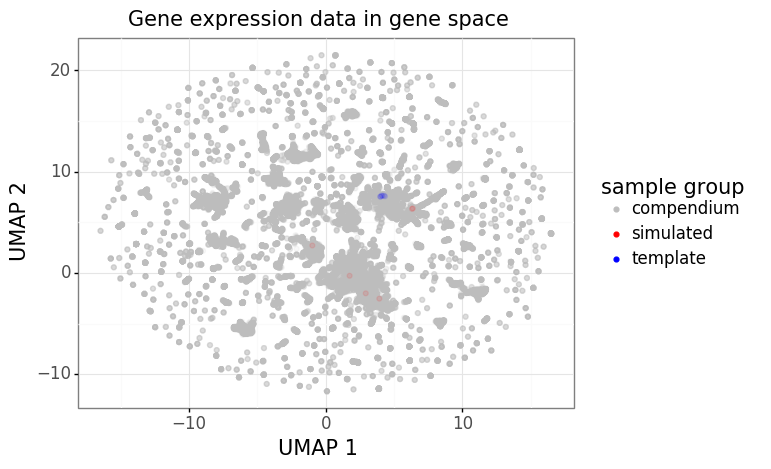

<ggplot: (8740360313101)>


In [17]:
# Drop label column
normalized_all_data_numeric = normalized_all_data.drop(['sample group'], axis=1)

model = umap.UMAP(random_state=1).fit(normalized_all_data_numeric)

normalized_all_data_UMAPencoded = model.transform(normalized_all_data_numeric)
normalized_all_data_UMAPencoded_df = pd.DataFrame(data=normalized_all_data_UMAPencoded,
                                         index=normalized_all_data.index,
                                         columns=['1','2'])

# Add back label column
normalized_all_data_UMAPencoded_df['sample group'] = normalized_all_data['sample group']

# Plot
fig = ggplot(normalized_all_data_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.1)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'Gene expression data in gene space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)

##  Visualize data in latent space

Visualize where template experiment gets embedded in latent space compared to the rest of the compendium (in latent space)

In [13]:
# Files
model_encoder_filename = glob.glob(os.path.join(model_dir, "*_encoder_model.h5"))[0]

weights_encoder_filename = glob.glob(os.path.join(model_dir, "*_encoder_weights.h5"))[0]

model_decoder_filename = glob.glob(os.path.join(model_dir, "*_decoder_model.h5"))[0]

weights_decoder_filename = glob.glob(os.path.join(model_dir, "*_decoder_weights.h5"))[0]

In [14]:
# Load saved models
loaded_model = load_model(model_encoder_filename, compile=False)
loaded_decode_model = load_model(model_decoder_filename, compile=False)

loaded_model.load_weights(weights_encoder_filename)
loaded_decode_model.load_weights(weights_decoder_filename)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [15]:
# Encode concatenated normalized data
normalized_data_encoded = loaded_model.predict_on_batch(normalized_all_data_numeric)
normalized_data_encoded_df = pd.DataFrame(normalized_data_encoded, index=normalized_all_data_numeric.index)

In [19]:
normalized_data_encoded_df.head()

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
sample10A.genes.results,0.000000,0.860087,0.360160,5.708364,2.698008,7.492296,7.896254,0.000000,0.0,0.0,...,1.967864,5.897185,0.968072,0.000000,0.000000,3.281833,2.309564,0.000000,11.237158,1.514079
sample10B.genes.results,0.246133,1.287690,0.975007,5.180852,2.415584,7.852037,6.790008,0.000000,0.0,0.0,...,3.246029,5.910819,1.052787,0.000000,0.000000,3.131008,4.086768,1.471204,10.774144,3.026047
sample10C.genes.results,2.310039,1.595360,5.312348,9.738501,1.515646,8.318390,3.210662,3.783037,0.0,0.0,...,7.775311,4.224432,2.006157,0.240847,3.510913,2.772137,7.117140,2.715039,8.920473,5.196483
sample9A.genes.results,1.500478,1.256196,2.909052,9.248671,1.279645,8.697508,5.650011,1.104696,0.0,0.0,...,5.725535,5.160228,3.063779,0.118826,2.390839,4.019320,4.478180,2.950872,8.841026,2.776198
sample9B.genes.results,0.000000,2.528898,1.736713,6.770602,1.138377,7.502092,10.179867,0.000000,0.0,0.0,...,3.867006,7.592912,2.433186,0.000000,0.035450,4.900094,2.572731,1.620977,9.911882,1.888649


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


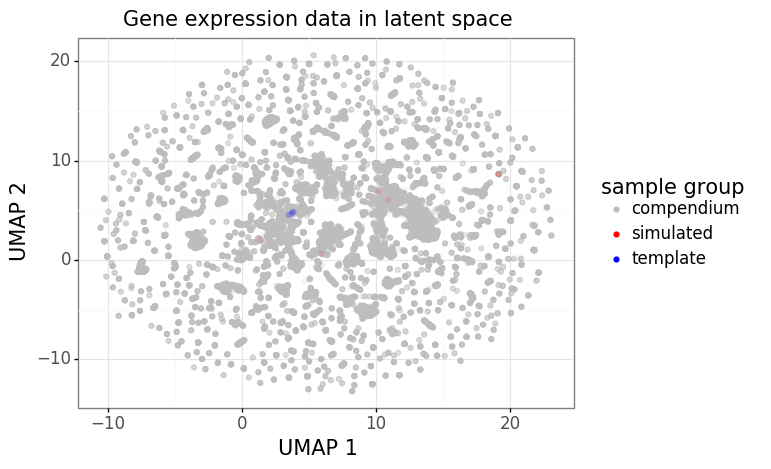

<ggplot: (8740349941173)>


In [18]:
model2 = umap.UMAP(random_state=1).fit(normalized_data_encoded_df)

normalized_encoded_data_UMAPencoded = model2.transform(normalized_data_encoded_df)
normalized_encoded_data_UMAPencoded_df = pd.DataFrame(data=normalized_encoded_data_UMAPencoded,
                                         index=normalized_data_encoded_df.index,
                                         columns=['1','2'])

# Add back label column
normalized_encoded_data_UMAPencoded_df['sample group'] = normalized_all_data['sample group']

# Plot
fig = ggplot(normalized_encoded_data_UMAPencoded_df, aes(x='1', y='2'))
fig += geom_point(aes(color='sample group'), alpha=0.1)
fig += labs(x ='UMAP 1',
            y = 'UMAP 2',
            title = 'Gene expression data in latent space')
fig += theme_bw()
fig += theme(
    legend_title_align = "center",
    plot_background=element_rect(fill='white'),
    legend_key=element_rect(fill='white', colour='white'), 
    legend_title=element_text(family='sans-serif', size=15),
    legend_text=element_text(family='sans-serif', size=12),
    plot_title=element_text(family='sans-serif', size=15),
    axis_text=element_text(family='sans-serif', size=12),
    axis_title=element_text(family='sans-serif', size=15)
    )
fig += scale_color_manual(['#bdbdbd', 'red', 'blue'])
fig += guides(colour=guide_legend(override_aes={'alpha': 1}))

print(fig)